In [427]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
import scipy.stats as stats
from statsmodels.tsa import api as tsa
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

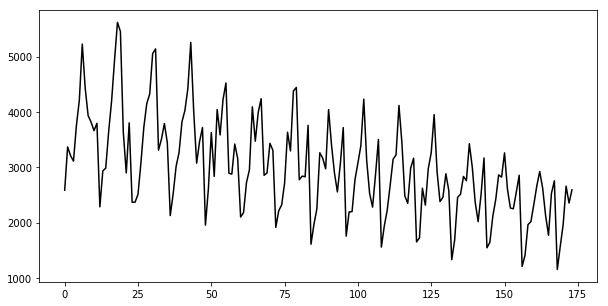

In [428]:
file = h5py.File('Fort.mat', 'r')
data = file.get('Fort')
Fort = np.array(data)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.show()

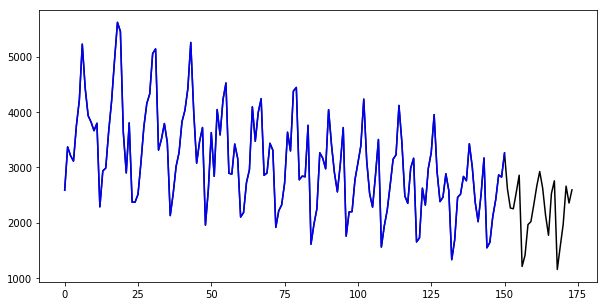

In [429]:
Z = Fort[:len(Fort)-24+1] # отрезаем последние 24 точки
t=np.arange(0, len(Z), 1) # временная шкала для регрессии
t=t.reshape(-1,1)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k') # исходный ВР
plt.plot(t, Z, 'b') # урезанный ряд
plt.show()

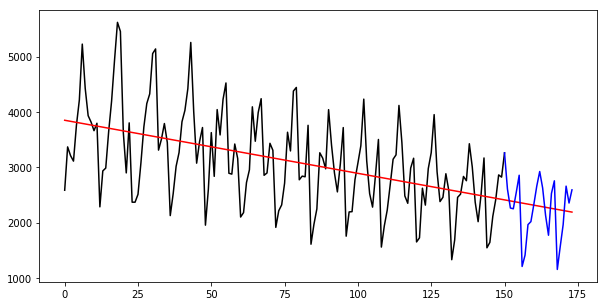

In [430]:
t=np.arange(0, len(Z), 1) # диапазон урезанного ряда
t=t.reshape(-1,1)
t0=np.arange(0, len(Fort), 1) # диапазон полного ряда
t0=t0.reshape(-1,1)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(t, Z) # модель регрессии
plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, reg.predict(t0), 'r') # прогноз на весь диапазон
plt.plot(t0[-24:], Fort[-24:], 'b') # реальные прогнозные значения
plt.show()

[3849.23884629   -9.58949808]


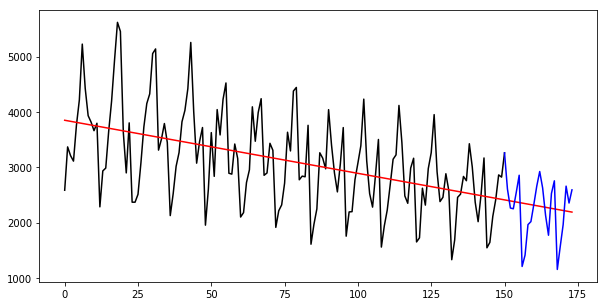

In [431]:
import statsmodels.api as sm
x_ = sm.add_constant(t)
smm = sm.OLS(Z, x_)
res = smm.fit() # строим модель регрессии
print(res.params)
plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, res.predict(sm.add_constant(t0)), 'r') # строим прогноз
plt.plot(t0[-24:], Fort[-24:], 'b') # реальные прогнозные значения
plt.show()

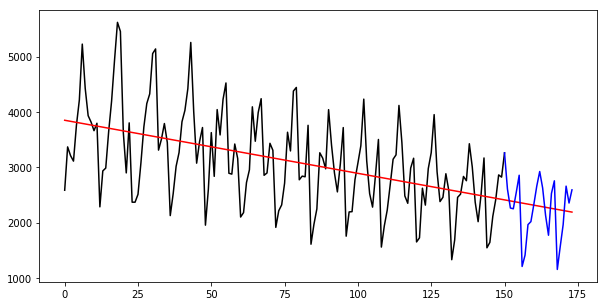

In [432]:
bb = np.polyfit(t.reshape(1,-1)[0], Z.reshape(1,-1)[0], 1)
p = np.poly1d(bb) # создаем экземпляр полинома
plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
plt.plot(t0, p(t0), 'r') # полином на прогнозной временной сетке
plt.plot(t0[-24:], Fort[-24:], 'b')
plt.show()

In [433]:
def estimate(Z1, F): #комплекс оценок из пункта 11
    #Средняя ошибка прогноза:
    midEx = np.zeros(len(Z1))
    for i in range(len(Z1)):
        midEx[i] = abs((Z1[i] - F[i]))
    delta = np.sum(midEx)/len(Z1)
    print('Средняя ошибка прогноза:', delta)
    #СКВО прогноза:
    midEx = np.zeros(len(Z1))
    for i in range(len(Z1)):
        midEx[i] = (Z1[i] - F[i])**2
    sigma = math.sqrt(np.sum(midEx)/len(Z1))
    print('СКВО прогноза:', sigma)
    #Средняя ошибка аппроксимации:
    midEx = np.zeros(len(Z1))
    for i in range(1, len(Z1)):
        midEx[i] = abs((Z1[i] - F[i]))/(Z1[i])
    epsilon = np.sum(midEx)*100/len(Z1)
    print('Средняя ошибка аппроксимации:', epsilon,'%')
    #Коэффициент несоответствия 1:
    midEx = np.zeros(len(Z1))
    y = np.zeros(len(Z1))
    for i in range(len(Z1)):
        midEx[i] = (F[i] - Z1[i])**2
        y[i] = Z1[i]**2
    KN1 = math.sqrt(np.sum(midEx)/np.sum(y))
    print('Коэффициент несоответствия 1:', KN1)
    #Коэффициент несоответствия 2:
    midEx = np.zeros(len(Z1))
    y = np.zeros(len(Z1))
    for i in range(len(Z1)):
        midEx[i] = (F[i] - Z1[i])**2
        y[i] = (np.mean(F) - Z1[i])**2
    KN2 = math.sqrt(np.sum(midEx)/np.sum(y))
    print('Коэффициент несоответствия 2:', KN2)

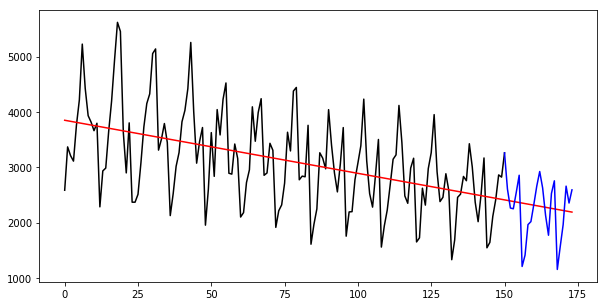

In [434]:
def func(t, b0, b1):
    return b0 + b1 * t
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, t.reshape(1,-1)[0], Z.reshape(1,-1)[0])
plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
ZZ1 = t0*popt[1]+popt[0]
plt.plot(t0, ZZ1, 'r')
plt.plot(t0[-24:], Fort[-24:], 'b')
plt.show()

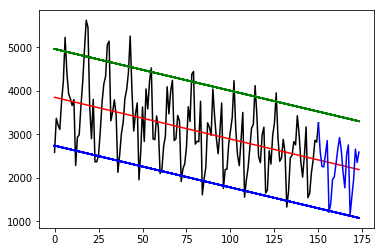

In [437]:
e = Fort[-24:] - ZZ1[-24:]

S = math.sqrt((np.sum(e**2))/(len(Fort[-24:])-2))

l = [np.mean(Fort[-24:]) for i in range(len(Fort[-24:]))]
#print(ZZ1[-24:] )
delta = np.zeros(len(Fort[-24:]))
ch = np.zeros(len(Fort[-24:]))
for i in range(len(Fort[-24:])):
    ch[i] = ZZ1[-24:][i]-l[i]
for i in range(len(ch)):
    delta[i] = 1.96 * S * math.sqrt(1+ 1/len(Fort[-24:]) + 
                               ((ch[i])**2/np.sum((Fort[-24:] - l)**2)))



plt.plot(t, Z, 'k')
plt.plot(t0, ZZ1 + delta, 'g')
plt.plot(t0, ZZ1 - delta, 'b')
plt.plot(t0, ZZ1, 'r')
plt.plot(t0[-24:], Fort[-24:], 'b')


In [438]:
#Fort[-24:]
estimate(ZZ1[-24:], Fort[-24:])

Средняя ошибка прогноза: 437.0172777967639
СКВО прогноза: 531.2841349811363
Средняя ошибка аппроксимации: 17.54463507846778 %
Коэффициент несоответствия 1: 0.23084331650040818
Коэффициент несоответствия 2: 7.125682176923734


In [262]:
#Регрессионная кривая второго порядка

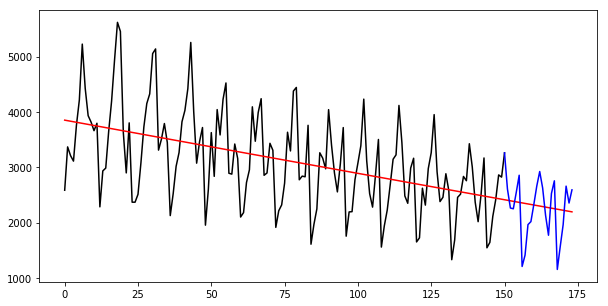

In [263]:
def func(t, b0, b1, b2):
    return b0 + b1 * t + b2*t**2 

from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, t.reshape(1,-1)[0], Z.reshape(1,-1)[0])
plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
ZZ2 = (t0**2)*popt[2] + t0*popt[1]+popt[0]
plt.plot(t0, ZZ2, 'r')
plt.plot(t0[-24:], Fort[-24:], 'b')
plt.show()

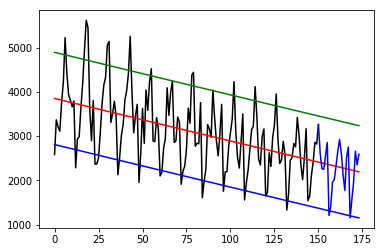

In [445]:
delta = np.zeros(len(Fort[-24:]))
ch = np.zeros(len(Fort[-24:]))
for i in range(len(Fort[-24:])):
    ch[i] = (ZZ2[-24:][i]-Fort[-24:][i])**2
delta = 1.96 * math.sqrt((np.sum(ch))/len(ZZ2[-24:]))
delta


plt.plot(t, Z, 'k')
plt.plot(t0, ZZ2 + delta, 'g')
plt.plot(t0, ZZ2 - delta, 'b')
plt.plot(t0, ZZ2, 'r')
plt.plot(t0[-24:], Fort[-24:], 'b')


In [446]:
estimate(ZZ2[-24:], Fort[-24:])

Средняя ошибка прогноза: 436.69908454591604
СКВО прогноза: 531.51357138277
Средняя ошибка аппроксимации: 17.50837932913839 %
Коэффициент несоответствия 1: 0.2306230040019553
Коэффициент несоответствия 2: 7.0417055639223705


In [447]:
#Регрессионная кривая третьего порядка

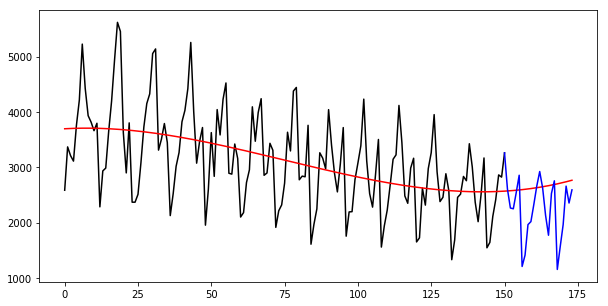

In [448]:
def func(t, b0, b1, b2, b3):
    return b0 + b1 * t + b2*(t**2) + b3*(t**3)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, t.reshape(1,-1)[0], Z.reshape(1,-1)[0])
plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
ZZ3 = (t0**3)*popt[3] + (t0**2)*popt[2] + t0*popt[1]+popt[0]
plt.plot(t0, (t0**3)*popt[3] + (t0**2)*popt[2] + t0*popt[1]+popt[0], 'r')
plt.plot(t0[-24:], Fort[-24:], 'b')
plt.show()

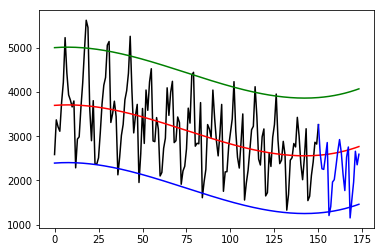

In [453]:
delta = np.zeros(len(Fort[-24:]))
ch = np.zeros(len(Fort[-24:]))
for i in range(len(Fort[-24:])):
    ch[i] = (ZZ3[-24:][i]-Fort[-24:][i])**2
delta = 1.96 * math.sqrt((np.sum(ch))/len(ZZ3[-24:]))
delta


plt.plot(t, Z, 'k')
plt.plot(t0, ZZ3 + delta, 'g')
plt.plot(t0, ZZ3 - delta, 'b')
plt.plot(t0, ZZ3, 'r')
plt.plot(t0[-24:], Fort[-24:], 'b')


In [451]:
estimate(ZZ3[-24:], Fort[-24:])

Средняя ошибка прогноза: 494.11283229413465
СКВО прогноза: 665.0082858768126
Средняя ошибка аппроксимации: 17.5434366383589 %
Коэффициент несоответствия 1: 0.25121922003430947
Коэффициент несоответствия 2: 1.7293215711513417


In [267]:
#часть 14

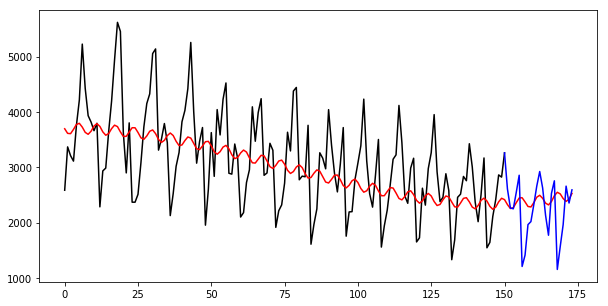

In [423]:
def func(t, b0, b1, b2, b3):
    return b0 + b1 * t + b2*(t**2) + b3*(t**3)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, t.reshape(1,-1)[0], Z.reshape(1,-1)[0])
plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k')
ZZZ = -100*np.sin(t0) + (t0**3)*popt[3] + (t0**2)*popt[2] + (t0)*popt[1]/2 + popt[0]
plt.plot(t0, ZZZ, 'r')
plt.plot(t0[-24:], Fort[-24:], 'b')
plt.show()

In [424]:
estimate(ZZZ[-24:], Fort[-24:])

Средняя ошибка прогноза: 408.4160802590993
СКВО прогноза: 558.9190653874325
Средняя ошибка аппроксимации: 15.338473668527264 %
Коэффициент несоответствия 1: 0.23275950239149734
Коэффициент несоответствия 2: 3.56954970702559


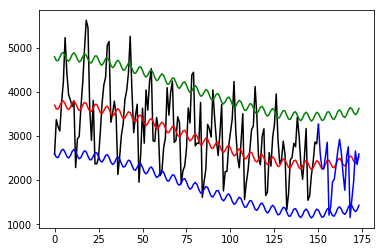

In [454]:
delta = np.zeros(len(Fort[-24:]))
ch = np.zeros(len(Fort[-24:]))
for i in range(len(Fort[-24:])):
    ch[i] = (ZZZ[-24:][i]-Fort[-24:][i])**2
delta = 1.96 * math.sqrt((np.sum(ch))/len(ZZZ[-24:]))
delta


plt.plot(t, Z, 'k')
plt.plot(t0, ZZZ + delta, 'g')
plt.plot(t0, ZZZ - delta, 'b')
plt.plot(t0, ZZZ, 'r')
plt.plot(t0[-24:], Fort[-24:], 'b')
